### Bibliotecas

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
from torchvision import datasets, transforms, utils

import os
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

### Parâmetros

In [ ]:
# Configuração para replicabilidade
torch.manual_seed(42)
np.random.seed(42)
torch.use_deterministic_algorithms(True)

workers = 2               # Workers do DataLoader
batch_size = 128          # Tamanho do batch
image_size = 64           # Tamanho final das imagens (resize)
nc = 1                    # Número de canais (RGB)
nz = 100                  # Dimensão do vetor latente z
ngf = 64                  # Largura da rede do gerador
ndf = 64                  # Largura da rede do discriminador
num_epochs = 10           # Número de épocas de treinamento
lr = 0.0001               # Taxa de aprendizado do Adam
beta1 = 0.5               # Beta1 do Adam
ngpu = 1                  # Número de GPUs (0 -> CPU)

dataroot = '../data'
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

### Dataloader

#### MNIST

Para MNIST (28×28), usando image_size = 64:

- O Resize(64) aumenta a imagem para 64×64
- CenterCrop garante que ela fique exatamente no tamanho desejado e bem centralizada

In [ ]:
dataset = datasets.MNIST( 
    root=dataroot,
    train=True,
    download=True,
    transform=
        transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) 
    ])
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

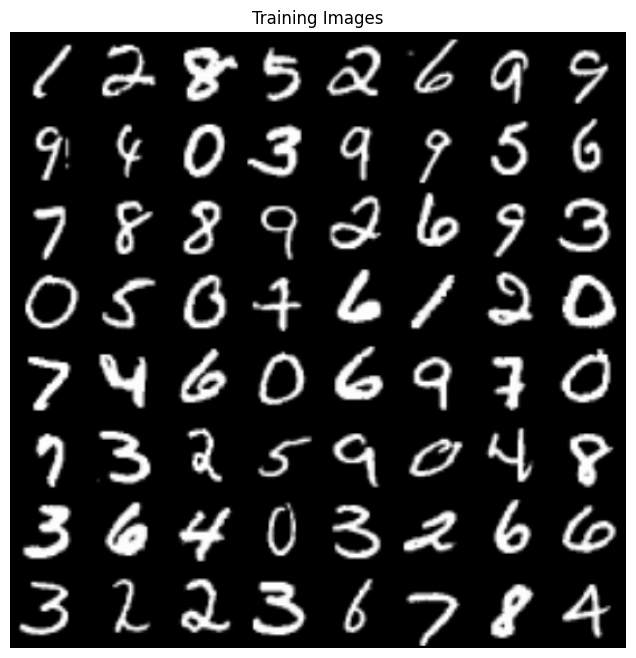

In [35]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Definição dos pesos

Levando em consideração o que foi mostrado no artigo, todos os pesos do modelo devem ser inicializados aleatoriamente a partir de uma distribuição Normal com média = 0 e desvio padrão = 0,02. É basicamentee isso que fazemos aqui. A função recebe um modelo inicializado como entrada e reinicializa todas as camadas convolucionais, convolucionais transpostas e de normalização em lote para atender a esses critérios. Justamente essa função é aplicada aos modelos imediatamente após a inicialização.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Arquitetura das redes

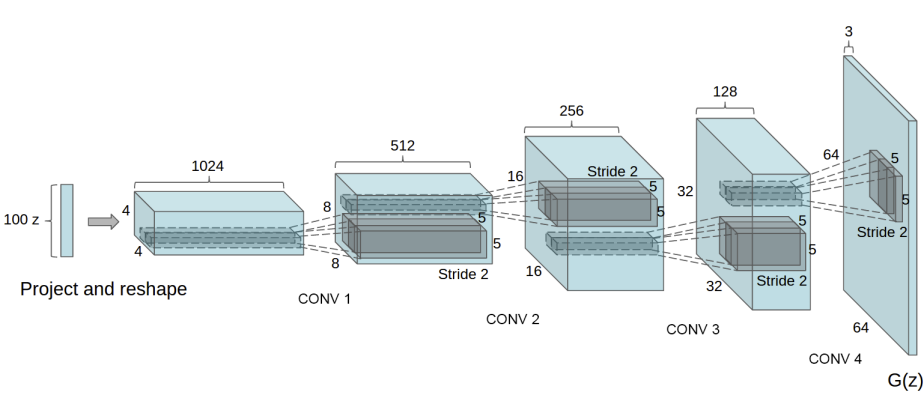

In [37]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print('#'*100)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Definições do modelo e otimizadores

No artigo eles definiram o rótulo real como 1 e o rótulo falso como 0. Esses rótulos serão usados ​​no cálculo das perdas de D e G e essa também é a convenção usada no artigo original do GAN. Vou implementar uma suavização de rótulos para tentar evidar o *mode collapse*

Usando a perda binária de entropia cruzada, a função de perda de $D$ (para os dados reais) se torna:

$$L_{D, real} = - \frac{1}{N} \sum_{i=1}^N [0.9 \cdot \log(D(x_i)) + (1-0.9) \cdot \log(1 - D(x_i))]$$

Onde o alvo é **$0.9$** em vez de $1.0$.

Se o $D(x_i)$ for $0.999$, a perda será mais alta do que se $D(x_i)$ fosse $0.90$, que seria a perda mínima ideal com este rótulo, pois o $D$ está sendo "superconfiante" em relação ao alvo $0.9$. Isso suaviza o gradiente e a atualização dos pesos.

Aproveito para configurar os dois otimizadores separados, um para D e outro para G, ambos são otimizadores Adam com taxa de aprendizado de 0,0001 e $\beta_1$ = 0,5.

O $\beta_1$ é usado para calcular o primeiro momento ($m_t$), que é a média móvel exponencial dos gradientes. Essa média é então usada para calcular a atualização dos pesos ($\theta$)

Para acompanhar o progresso do aprendizado do gerador, pensei em gerar um lote fixo de vetores latentes extraídos de uma distribuição gaussiana e inseri isso no loop de treinamento, ao longo das iterações. Assim dá para ver as imagens se formarem a partir do ruído, o que dá um percepção boa do que acontece por trás dos códigos.

In [69]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 0.9
fake_label = 0.1

optimizerD = optim.Adam(netD.parameters(), lr=lr/4, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Treinamento

A real é a seguinte: Treinar essa rede aqui é para quem é louco. É escalar montanha sem equipamento. Errou um hiperparâmetros tudo colapsa com pouca explicação sobre o que deu errado. 

O Algoritmo 1 do artigo sugeri construir mini-lotes diferentes para imagens reais e falsas e ajustar a função objetivo de G para maximizar $log(D(G(z)))$

O treinamento é dividido em duas partes principais. A Parte 1 atualiza o Discriminador e a Parte 2 atualiza o Gerador.

As estatísticas de treinamento relatadas são:

$Loss_D$ - perda do discriminador calculada como a soma das perdas para os lotes com todos os dados reais e todos os dados falsos $log(D(x))+log(1−D(G(z)))$

$Loss_G$ - perda do gerador calculada como $log(D(G(z)))$

$D(x)$ - a saída média (em todo o lote) do discriminador para o lote com todos os dados reais. Este valor deve começar próximo de 1 e, teoricamente, convergir para 0,5 quando G apresentar melhor desempenho. Pense no porquê disso.

$D(G(z))$ - média das saídas do discriminador para o lote totalmente falso. O primeiro número é antes da atualização de D e o segundo número é depois da atualização de D. Esses números devem começar próximos de 0 e convergir para 0,5 à medida que G melhora. Pense no porquê disso.

In [70]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/469]	Loss_D: 2.6820	Loss_G: 6.3924	D(x): 0.9998	D(G(z)): 0.0001 / 0.0011
[0/10][50/469]	Loss_D: 0.7414	Loss_G: 1.9087	D(x): 0.8507	D(G(z)): 0.0902 / 0.1270
[0/10][100/469]	Loss_D: 0.7123	Loss_G: 1.8190	D(x): 0.8399	D(G(z)): 0.1300 / 0.1370
[0/10][150/469]	Loss_D: 0.6774	Loss_G: 2.1892	D(x): 0.8839	D(G(z)): 0.0869 / 0.0898
[0/10][200/469]	Loss_D: 0.7043	Loss_G: 2.3893	D(x): 0.8653	D(G(z)): 0.0460 / 0.0720
[0/10][250/469]	Loss_D: 0.6636	Loss_G: 2.2988	D(x): 0.8999	D(G(z)): 0.0893 / 0.0791
[0/10][300/469]	Loss_D: 0.6902	Loss_G: 1.8652	D(x): 0.8461	D(G(z)): 0.1472 / 0.1284
[0/10][350/469]	Loss_D: 0.6620	Loss_G: 2.0700	D(x): 0.8998	D(G(z)): 0.1054 / 0.1020
[0/10][400/469]	Loss_D: 0.6610	Loss_G: 2.0902	D(x): 0.9021	D(G(z)): 0.0952 / 0.0996
[0/10][450/469]	Loss_D: 0.6610	Loss_G: 1.8617	D(x): 0.8832	D(G(z)): 0.0969 / 0.1289
[1/10][0/469]	Loss_D: 0.6706	Loss_G: 1.9359	D(x): 0.8947	D(G(z)): 0.1502 / 0.1187
[1/10][50/469]	Loss_D: 0.6661	Loss_G: 2.1378	D(x): 0.87

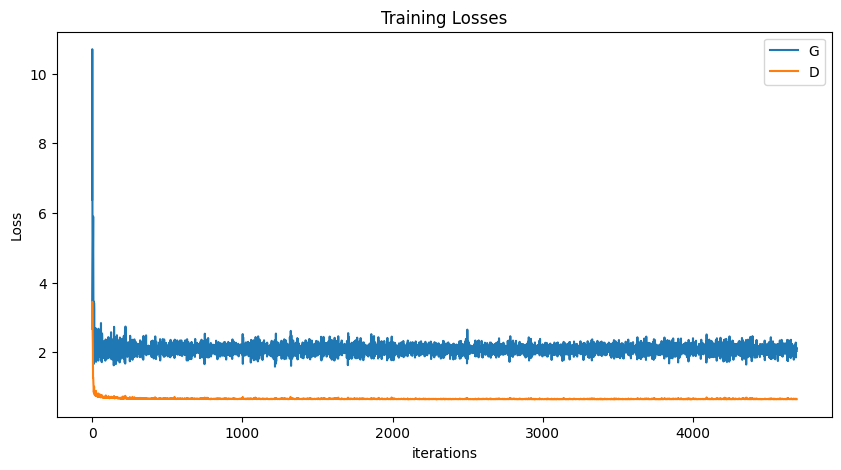

In [71]:
plt.figure(figsize=(10,5))
plt.title("Training Losses")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

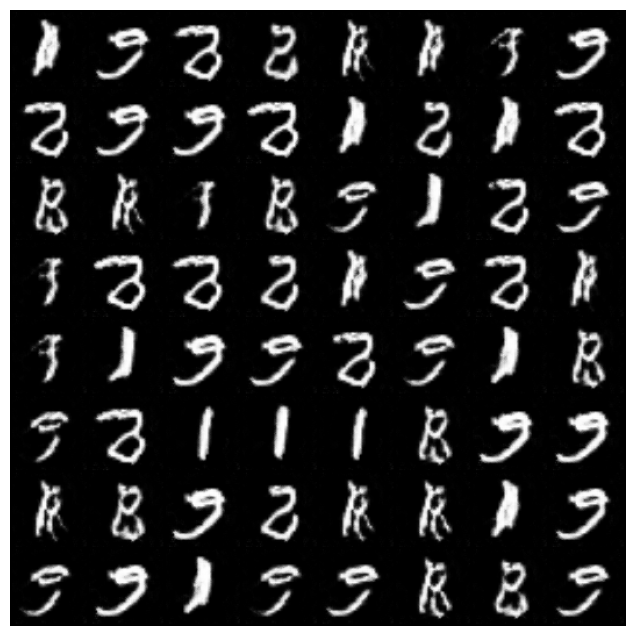

In [72]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

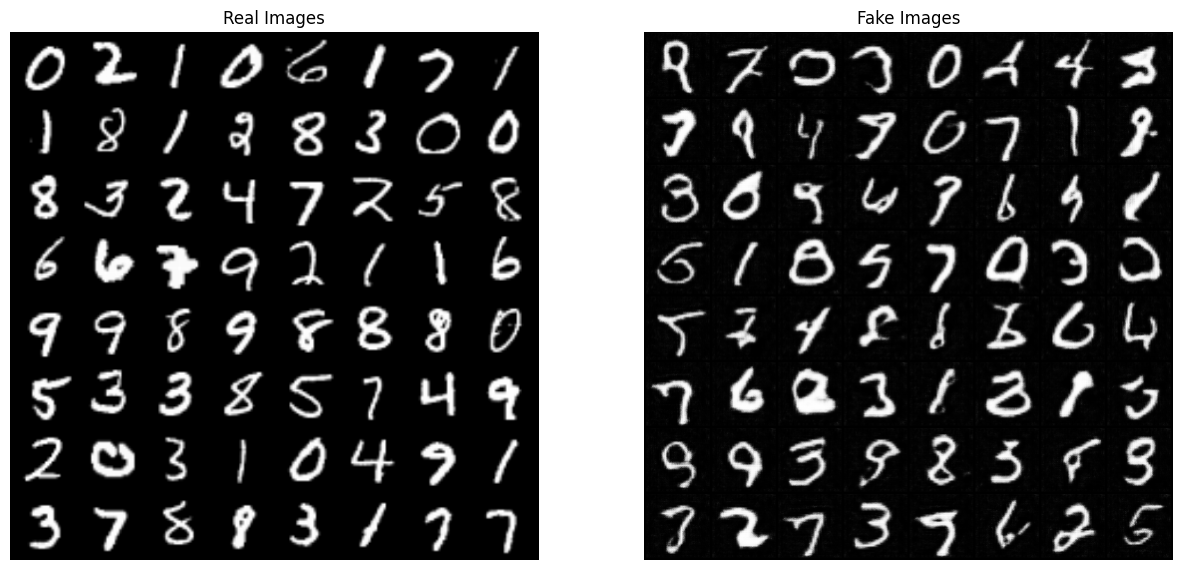

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()